In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import japanize_matplotlib

In [15]:
file_path = "./logs/up-down/"
df_mag = pd.read_csv(
    f"{file_path}Magnetometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)

df_acc = pd.read_csv(
    f"{file_path}Accelerometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)



In [16]:
df_mag["angle"] = df_mag.apply(
    lambda row: np.degrees(math.atan2(row["x"], row["y"])),
    axis=1
)

In [17]:
# グラフを描画する
def plot(
    df,
    heads=[],
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(10, 3),
    xlim=(0, 0),
    ylim=(0, 0),
    grid=True,
):
    fig = plt.figure(figsize=figsize)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if grid:
        plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    if xlim[0] < xlim[1]:
        plt.xlim(xlim[0], xlim[1])
    if ylim[0] < ylim[1]:
        plt.ylim(ylim[0], ylim[1])

    for head in heads:
        plt.plot(df[head[0]], df[head[1]], label=head[1])

    plt.legend()

    plt.show()


# 傾きを計算する
def calculate_tilt(df_acc):
    tilt_angles = []  # 傾きを格納するリスト

    # df を for で回す
    for d in df_acc.itertuples(index=False):
        time = d.time
        x = d.x
        y = d.y
        z = d.z

        gravity = math.sqrt(x ** 2 + y ** 2 + z ** 2)

        # 重力方向となす角度を計算
        tilt_angle_x = math.acos(x / gravity)
        tilt_angle_y = math.acos(y / gravity)
        tilt_angle_z = math.acos(z / gravity)

        tilt_angles.append((time, tilt_angle_x, tilt_angle_y, tilt_angle_z))

    df_tilt = pd.DataFrame(tilt_angles, columns=[
                           "time", "roll", "pitch", "yaw"])
    return df_tilt


# ベクトルを回転させる
def rotate(vec, pitch, roll, yaw):
    r_x = np.array([
        [1, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch)],
        [0, np.sin(pitch), np.cos(pitch)]
    ])
    r_y = np.array([
        [np.cos(roll), 0, np.sin(roll)],
        [0, 1, 0],
        [-np.sin(roll), 0, np.cos(roll)]
    ])
    r_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    vec = np.dot(r_x, vec)
    vec = np.dot(r_y, vec)
    vec = np.dot(r_z, vec)

    return vec


# 端末座標系を端末の向きに合わせて回転させる
def rotate_device_coordinate_system(df_acc):
    new_df = []
    for data in df_acc.iterrows():
        # 元のベクトル
        x = data[1]['x']
        y = data[1]['y']
        z = data[1]['z']

        vec = np.array([x, y, z])

        # 回転後のベクトル
        vec_dash = rotate(
            vec,
            data[1]['yaw'],
            data[1]['roll'],
            data[1]['pitch']
        )

        # 回転後の値を格納
        new_df.append([
            data[1]['time'],
            vec_dash[0],
            vec_dash[1],
            vec_dash[2],
        ])

    new_df = pd.DataFrame(new_df, columns=['time', 'x', 'y', 'z'])
    return new_df


# 加速度から傾きのnumpy配列を取得する
def get_tilts_from_acc(df_acc):
    df_tilt = calculate_tilt(df_acc)
    df_tilt['roll'] = df_tilt['roll'] - np.radians(90)
    df_tilt['pitch'] = df_tilt['pitch'] - np.radians(90)

    tilts = []
    for data in df_acc.iterrows():
        # 傾きを取得
        tilt = df_tilt[df_tilt['time'] == data[1]['time']]
        tilts.append((
            tilt['pitch'].values[0],
            tilt['roll'].values[0],
            tilt['yaw'].values[0]
        ))

    tilts = np.array(tilts)

    return tilts


# 傾きを元に磁気センサーを世界座標に回転させる
def rotate_mag(df_mag):
    new_df = []
    for data in df_mag.iterrows():
        # 元のベクトル
        vec = np.array([data[1]['x'], data[1]['y'], data[1]['z']])
        vec_dash = rotate(
            vec,
            data[1]['yaw'],
            data[1]['roll'],
            data[1]['pitch']
        )

        # 回転後の値を格納
        new_df.append([
            data[1]['time'],
            vec_dash[0],
            vec_dash[1],
            vec_dash[2],
        ])

    new_df = pd.DataFrame(new_df, columns=['time', 'x', 'y', 'z'])
    return new_df


# df 中の target_time に最も近い time を返す
def get_nearest_time(df, target_time):
    # "time"列と目標時間との差分を計算
    df['time_diff'] = (df['time'] - target_time).abs()

    # 差分の絶対値が最小となる行を取得
    nearest_row = df.loc[df['time_diff'].idxmin()]

    # 最も近い時間の値を取得
    nearest_time = nearest_row['time']

    # "time_diff"列を削除
    df = df.drop(columns=['time_diff'])

    return nearest_time


In [18]:
tilts = get_tilts_from_acc(df_acc)

# df_acc に "roll", "pitch", "yaw" 列を追加
df_acc['pitch'] = tilts[:, 0]
df_acc['roll'] = tilts[:, 1]
df_acc['yaw'] = tilts[:, 2]


# 重力加速度を用いて端末座標を世界座標に
rotated_df_acc = rotate_device_coordinate_system(df_acc)


In [19]:
tilts = []
for data in df_mag.iterrows():
    nearest_time = get_nearest_time(df_acc, data[1]['time'])
    tilt = df_acc[df_acc['time'] == nearest_time]
    roll = tilt['roll']
    pitch = tilt['pitch']
    yaw = tilt['yaw']
    tilts.append((pitch, roll, yaw))

tilts = np.array(tilts)

# df_mag に "roll", "pitch", "yaw" 列を追加
df_mag['pitch'] = tilts[:, 0]
df_mag['roll'] = tilts[:, 1]
df_mag['yaw'] = tilts[:, 2]

rotated_df_mag = rotate_mag(df_mag)
rotated_df_mag["angle"] = rotated_df_mag.apply(
    lambda row: np.degrees(math.atan2(row["x"], row["y"])),
    axis=1
)


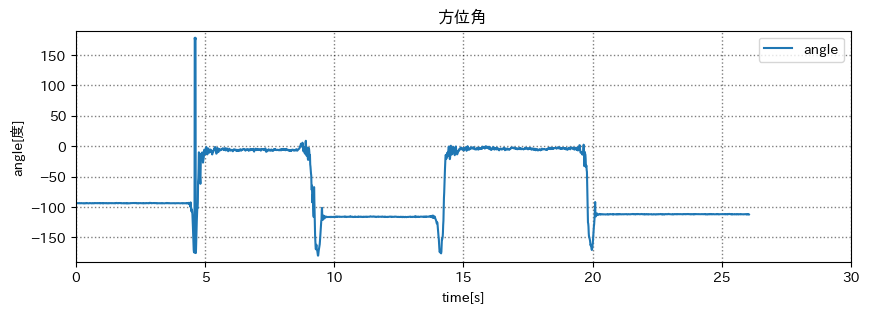

In [20]:
plot(
    rotated_df_mag,
    heads=[
        ("time", "angle"),
    ],
    title="方位角",
    xlabel="time[s]",
    ylabel="angle[度]",
    xlim=(0, 30),
    ylim=(-190, 190),
    grid=True,
)

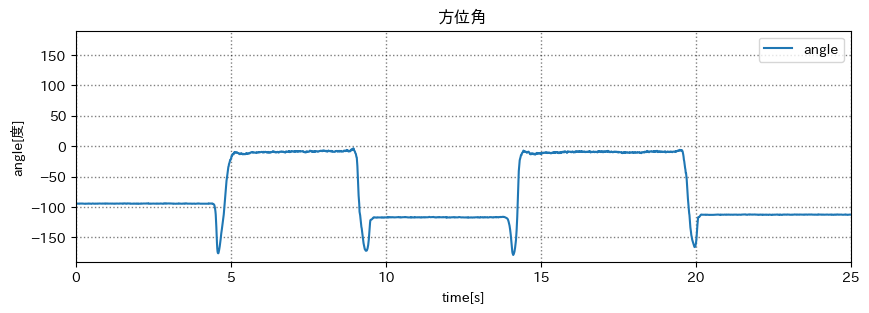

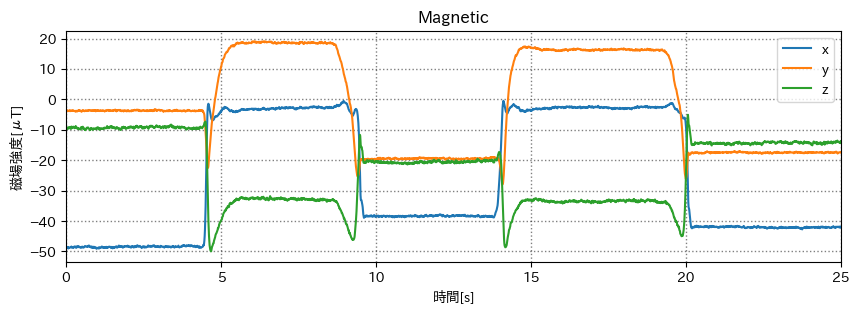

In [22]:
plot(
    df_mag,
    heads=[
        ("time", "angle"),
    ],
    title="方位角",
    xlabel="time[s]",
    ylabel="angle[度]",
    xlim=(0, 25),
    ylim=(-190, 190),
    grid=True,
)

plot(
    df_mag,
    heads=[
        ("time", "x"),
        ("time", "y"),
        ("time", "z"),
    ],
    title="Magnetic",
    xlabel="時間[s]",
    ylabel="磁場強度[μT]",
    xlim=(0, 25),
    # ylim=(-190, 190),
    grid=True,
)
